# 深层神经网络
pytorch实现一下mnist手写体识别

In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable

#导入数据集
from torchvision.datasets import mnist

In [2]:
#下载数据集
train_set=mnist.MNIST('./data',train=True,download=True)
test_set=mnist.MNIST('./data',train=True,download=True)

Processing...
Done!


In [3]:
#看一下长啥样
a_data,a_label=train_set[0]

In [4]:
a_data

In [5]:
a_label

tensor(5)

In [6]:
# 转换为numpy格式
a_data=np.array(a_data,dtype='float32')
print(a_data.shape)

(28, 28)


In [7]:
print(a_data)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.  

对于神经网络，我们第一层的输入就是 28 x 28 = 784，所以必须将得到的数据我们做一个变换，使用 reshape 将他们拉平成一个一维向量

In [9]:
def data_tf(x):
    x=np.array(x,dtype='float32')/255
    x=(x-0.5)/0.5 #标准化
    x=x.reshape((-1,)) #拉平
    x=torch.Tensor(x)
    return x
train_set=mnist.MNIST('./data',train=True,transform=data_tf,download=True)
test_set=mnist.MNIST('./data',train=False,transform=data_tf,download=True)


In [10]:
a,a_label=train_set[0]
print(a.shape)
print(a_label)

torch.Size([784])
tensor(5)


In [12]:
#使用迭代器
from torch.utils.data import DataLoader

train_data=DataLoader(train_set,batch_size=64,shuffle=True)
test_data=DataLoader(test_set,batch_size=128,shuffle=False)

In [13]:
a,a_label=next(iter(train_data))

In [15]:
#打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([64, 784])
torch.Size([64])


In [16]:
# 定义模型,我们使用module
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.layer1=nn.Linear(784,400)
        self.layer2=nn.ReLU()
        self.layer3=nn.Linear(400,200)
        self.layer4=nn.ReLU()
        self.layer5=nn.Linear(200,100)
        nn.ReLU()
        nn.Linear(100,10)
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        return x

In [18]:
net=Net()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),1e-1)

In [19]:
# 开始训练

losses = []
acces = []
eval_losses = []
eval_acces = []
for e in range(20):
    train_loss=0
    train_acc=0
    #模型训练模式,这个方法应该是nn.Module()自带的方法,我们的模型继承了这个方法.
    net.train()
    for im,label in train_data:
        out=net.forward(Variable(im))
        loss=criterion(out,Variable(label))
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #记录loss
        train_loss+=loss.item()
        #计算分类的准确率
        _,pred=out.max(1)
        num_correct=(pred==label).sum().item()
        acc=num_correct/im.shape[0]
        train_acc+=acc
    #计算每个epoch中所有样本的平均loss
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc  
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 0.485260, Train Acc: 0.850130, Eval Loss: 0.354189, Eval Acc: 0.880835
epoch: 1, Train Loss: 0.166675, Train Acc: 0.948777, Eval Loss: 0.117602, Eval Acc: 0.964992
epoch: 2, Train Loss: 0.116970, Train Acc: 0.963803, Eval Loss: 0.181338, Eval Acc: 0.938093
epoch: 3, Train Loss: 0.091746, Train Acc: 0.971332, Eval Loss: 0.093791, Eval Acc: 0.970134
epoch: 4, Train Loss: 0.074834, Train Acc: 0.976363, Eval Loss: 0.095703, Eval Acc: 0.968651
epoch: 5, Train Loss: 0.061360, Train Acc: 0.980844, Eval Loss: 0.075174, Eval Acc: 0.976167
epoch: 6, Train Loss: 0.051204, Train Acc: 0.983775, Eval Loss: 0.063587, Eval Acc: 0.980419
epoch: 7, Train Loss: 0.043121, Train Acc: 0.986491, Eval Loss: 0.068393, Eval Acc: 0.978244
epoch: 8, Train Loss: 0.036760, Train Acc: 0.988023, Eval Loss: 0.064650, Eval Acc: 0.979925
epoch: 9, Train Loss: 0.031247, Train Acc: 0.989872, Eval Loss: 0.063604, Eval Acc: 0.981606
epoch: 10, Train Loss: 0.027958, Train Acc: 0.990805, Eval Loss: 0.075

#### 扩展: `tensor.item()`:取tensor中的元素值.
- 注意,这个tensor的shape必须是1.
- 返回的数据类型是float或者int,这个根据tensor类型变化

In [27]:
a=torch.randn(1)
print(a)
print(a.item())

tensor([0.2532])
0.25319498777389526


## 展示训练结果

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

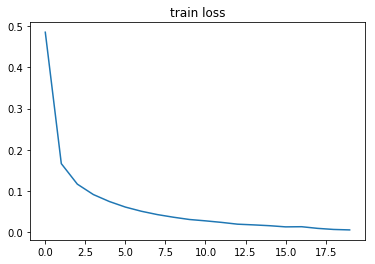

In [29]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)

Text(0.5,1,'train acc')

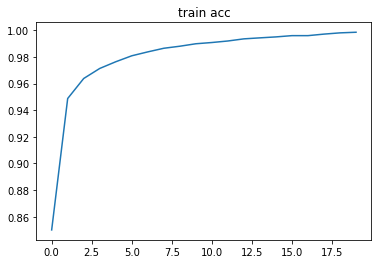

In [30]:
plt.plot(np.arange(len(acces)), acces)
plt.title('train acc')

Text(0.5,1,'test loss')

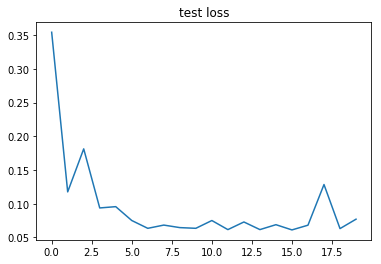

In [31]:
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')

Text(0.5,1,'test acc')

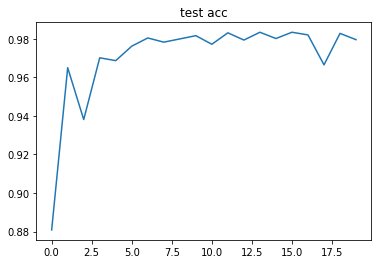

In [32]:
plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.title('test acc')

## 小结
1. tensor.item():获取1维tensor元素值,多用于计算acc中